## EDA

In [ ]:
! pip install statsmodels

In [148]:
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib as mpl
from datetime import datetime
from matplotlib.gridspec import GridSpec


import scipy.stats as stats
import statsmodels.api as sm


from scipy.stats import f_oneway
from scipy.stats import chi2_contingency
from statsmodels.formula.api import ols

import warnings
from typing import List, Optional

pd.set_option('max_columns', None)
pd.set_option('max_rows', None)
pd.options.display.float_format = "{:,.2f}".format


warnings.filterwarnings('ignore')



#helper functions for plotting


def plot_count(col_list: List[str], 
              df:pd.DataFrame, 
               hue: Optional[str] = None):

    for col in col_list:
        plt.figure(figsize=(20, 5))
        sns.countplot(x=col, data=df,
                     hue=hue, order=df[col].value_counts().index)
        plt.title(f"{col} distribution")
        plt.show()


def plot_hist_count(col_list: List[str],
               df: pd.DataFrame,
               hue: Optional[str] = None, 
               stat:Optional[str] = None,
               multiple:Optional[str] = None):

    for col in col_list:
        plt.figure(figsize=(20, 5))
        sns.histplot(x=col, data=df,
                      hue=hue, stat=stat, 
                      multiple=multiple)
        plt.title(f"cat plot for {col} distribution")
        plt.show()


def merge_cols_use(cols_list: List[str],
                   primary_df: pd.DataFrame,
                   secondary_df: pd.DataFrame):

    check_cols = cols_list
    cols_checked_df = primary_df[check_cols]
    final_df = pd.concat([secondary_df, cols_checked_df], axis=1)
    final_df.dropna(inplace=True)

    return final_df


In [ ]:
accident_df = pd.read_csv('Road Safety Data - Accidents 2019.csv')
casualties_df = pd.read_csv('Road Safety Data - Casualties 2019.csv')
vehicles_df = pd.read_csv('Road Safety Data- Vehicles 2019.csv')

In [ ]:
def get_len(df_list):

  for df in df_list:
    print(f"{df.shape}")
  

get_len([accident_df, casualties_df, vehicles_df])

(117536, 32)
(153158, 16)
(216381, 23)


In [ ]:
acc_cas_df = pd.merge(accident_df, casualties_df, how='inner')
print(acc_cas_df.shape)
over_df = vehicles_df.merge(acc_cas_df, how='inner')
print(over_df.shape)

(128593, 47)
(109518, 68)


In [ ]:
over_df.columns
print(f"The number of columns is {len(over_df.columns)}")

The number of columns is 68


## 1.1 Data Summary

In [ ]:
over_df.head()
Output = False

In [ ]:
# get data summary 
def get_data_summary(data):
    summary = pd.concat([data.dtypes, data.nunique(),
                         data.count(), data.isnull().sum()],
                        keys=["dtypes", "nunique", "count", "missing"],
                        axis=1)
    return summary

summary_ = get_data_summary(over_df)
summary_


,dtypes,nunique,count,missing
Accident_Index,object,84165,109518,0
Vehicle_Reference,int64,11,109518,0
Vehicle_Type,int64,21,109518,0
Towing_and_Articulation,int64,7,109518,0
Vehicle_Manoeuvre,int64,19,109518,0
Vehicle_Location-Restricted_Lane,int64,11,109518,0
Junction_Location,int64,10,109518,0
Skidding_and_Overturning,int64,7,109518,0
Hit_Object_in_Carriageway,int64,13,109518,0
Vehicle_Leaving_Carriageway,int64,10,109518,0


### 1a. Is there a relationship between hours of the day, days of the week and number of accidents?

In [ ]:
col_list = ['Date','Time', 'Day_of_Week', 'Number_of_Casualties',
            'Number_of_Vehicles', 'Casualty_Severity', 'Accident_Severity']

cas_df = over_df[col_list]


In [98]:
cas_df['date_time'] = cas_df['Date'] + " " + cas_df['Time'] 
cas_df = cas_df.drop(columns=['Date', 'Time'], axis=1)
cas_df['date_time'] = pd.to_datetime(cas_df['date_time'])

cas_df = cas_df.dropna(subset=['date_time'], axis=0, inplace=False)

cas_df['date_time'] = cas_df['date_time'].apply(lambda dt: datetime(
    dt.year, dt.month, dt.day, dt.hour, 60*(dt.minute // 600)))

cas_df['hour_of_day'] = cas_df['date_time'].dt.hour


In [99]:
cas_df['Time_Duration'] = np.where((cas_df['hour_of_day'] >= 0) & (cas_df['hour_of_day'] <= 3), "before 3am", 
        np.where(
            (cas_df['hour_of_day'] > 3) & (cas_df['hour_of_day'] <= 6), "3am - 6am",
        np.where(
            (cas_df['hour_of_day'] > 6) & (cas_df['hour_of_day'] <= 9), "6am - 9am", 
        np.where(
            (cas_df['hour_of_day'] > 9) & (cas_df['hour_of_day'] <= 12), "9am - 12pm", 
        np.where(
            (cas_df['hour_of_day'] > 12) & (cas_df['hour_of_day'] <= 15), "12pm - 3pm", 
        np.where(
            (cas_df['hour_of_day'] > 15) & (cas_df['hour_of_day'] <= 18), "3pm -6pm", 
        np.where(
            (cas_df['hour_of_day'] > 18) & (cas_df['hour_of_day'] <= 21), "6pm - 9pm", 
        np.where(
            (cas_df['hour_of_day'] > 21) & (cas_df['hour_of_day'] <=24), "9pm - 12am", ""))))))))

In [100]:
# replace day of week with categorical values 
replace_dict = {
    1:"Sunday", 2:"Monday", 3:"Tuesday", 4:"Wednesday", 5:"Thursday", 6:"Friday", 7:"Saturday"
}

cas_df['Day_of_Week'] = cas_df['Day_of_Week'].replace(replace_dict)

#replace Accident_severity

replace_cas_dict = {
    1:"Fatal", 2:"Serious", 3:"Slight"
}

cas_df['Accident_Severity'] = cas_df['Accident_Severity'].replace(replace_cas_dict)

# replace Casualty Severity

replace_sev = {
    1: "Fatal", 2: "Serious", 3: "Slight"
}
cas_df['Casualty_Severity'] = cas_df['Casualty_Severity'].replace(
    replace_sev)




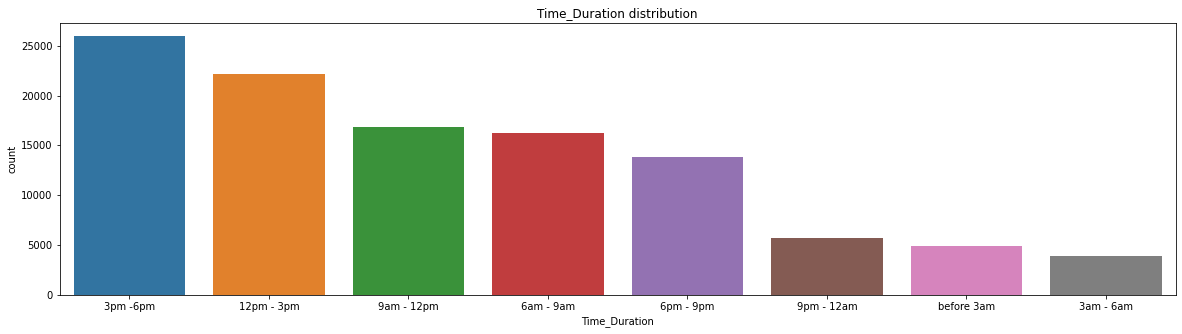

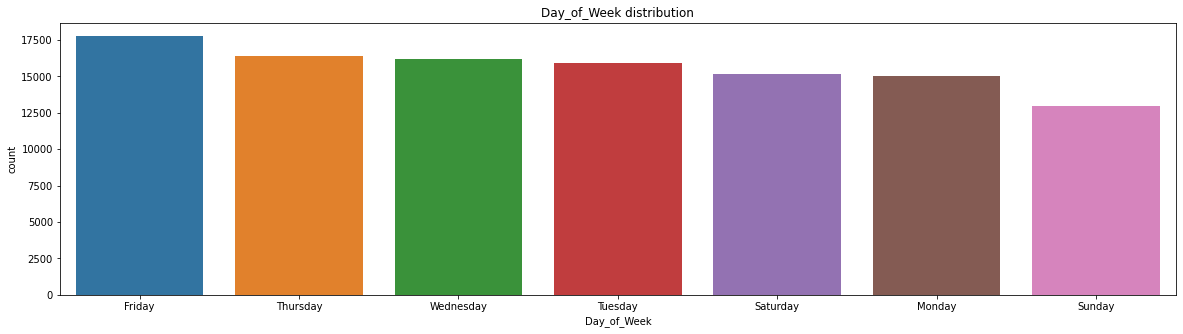

In [101]:
columns= ['Time_Duration', 'Day_of_Week']

plot_count(columns, cas_df, None)


### 1b. Are there significant hours of the day, day of the week for motorbike accidents 

In [102]:
over_df.head()
output=False

In [103]:
cols_to_check = ['Vehicle_Reference', 'Vehicle_Type']
vehicle_check_df = merge_cols_use(cols_to_check, over_df, cas_df )


In [104]:
motorCycle_codes = [2, 3, 4, 5, 23, 97]
motorCycle_df = vehicle_check_df[vehicle_check_df.Vehicle_Type.astype("int64").isin(
                motorCycle_codes)]



In [105]:

vehicle_replace_dict = {
    2:"Motorcycle 50cc and under", 
    3:"Motorcycle 125cc and under",
    4:"Motorcycle over 125cc and up to 500cc",
    5:"Motorcycle over 500cc",
    23:"Electric motorcycle",
    97: "Motorcycle - unknown cc"
}
motorCycle_df['Vehicle_Type'] = motorCycle_df['Vehicle_Type'].replace(
    vehicle_replace_dict)

# vehicle_check_df.isnull().sum()

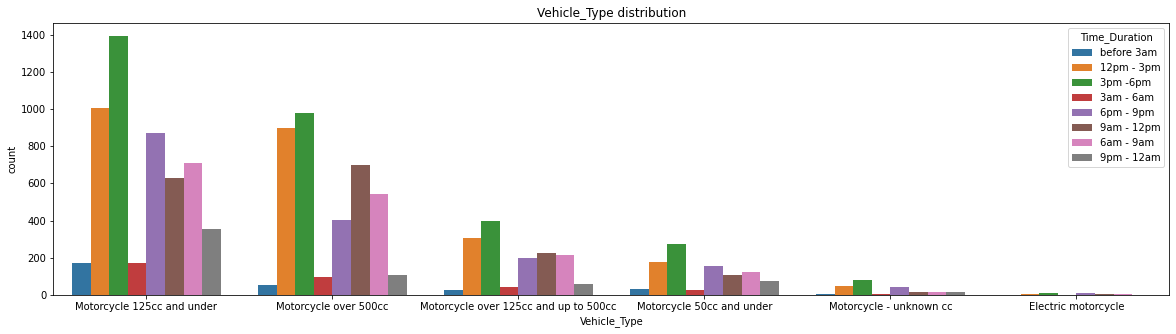

In [106]:
plot_count(['Vehicle_Type'], motorCycle_df, 'Time_Duration')

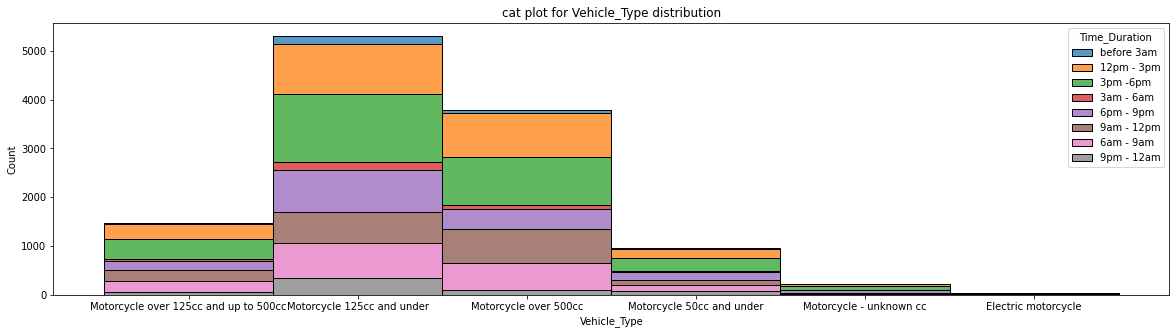

In [107]:
plot_hist_count(['Vehicle_Type'], motorCycle_df, 
                'Time_Duration', 'count', 'stack')


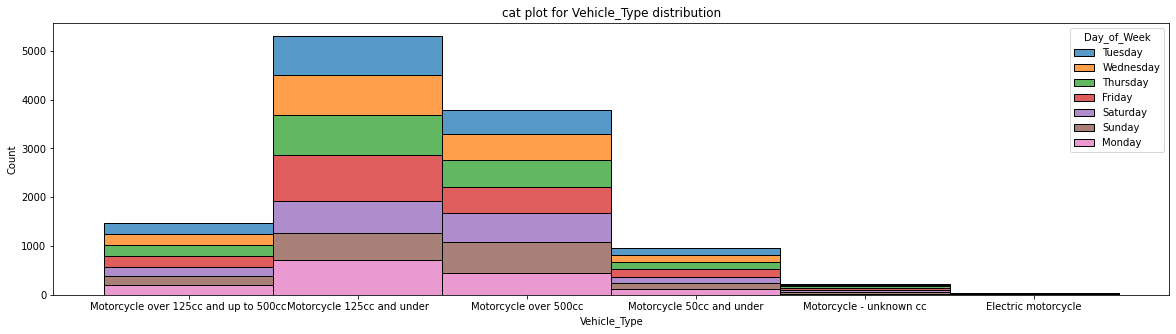

In [108]:
plot_hist_count(['Vehicle_Type'], motorCycle_df,
                'Day_of_Week', 'count', 'stack')


### 1c. Are there significant hours for pedestrians or day of the week for accident involvement?

In [109]:
casualty_cols = ['Casualty_Class']
pedestrian_df = merge_cols_use(casualty_cols, over_df, cas_df)
pedestrian_codes = [3]
pedestrian_df = pedestrian_df[pedestrian_df.Casualty_Class.astype("int64").isin(
    pedestrian_codes)]

ped_dict = {3:'Pedestrian'}
pedestrian_df['Casualty_Class'] = pedestrian_df['Casualty_Class'].replace(ped_dict)

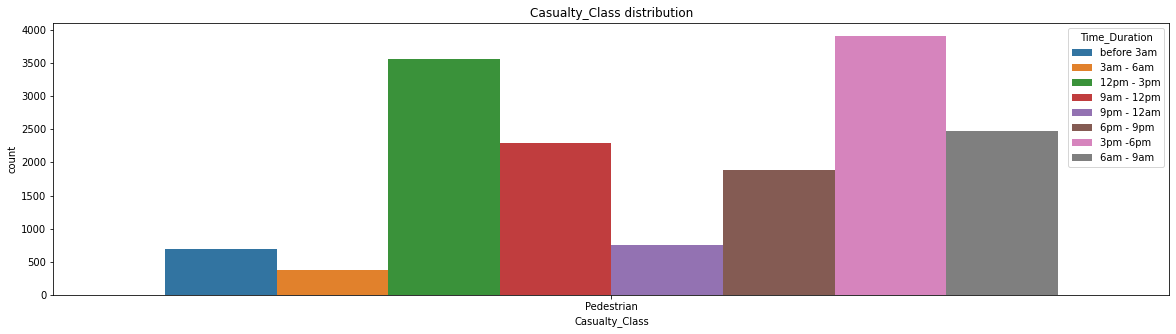

In [110]:
plot_count(['Casualty_Class'], pedestrian_df, 'Time_Duration')


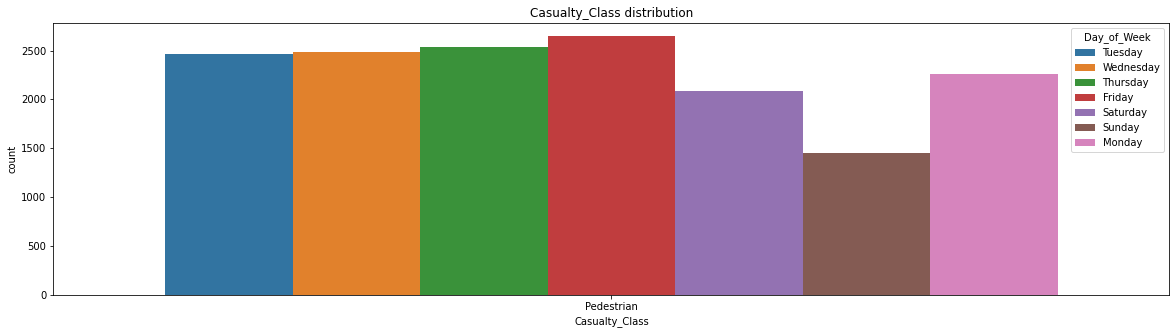

In [111]:
plot_count(['Casualty_Class'], pedestrian_df, 'Day_of_Week')


### 1d. Impact of Daylights on Road Traffic Accidents 

+ daylight_savings_start = 1am, Sunday 31st March
+ daylight_savings_end = 2am, Sunday 27th October 

In [112]:
import matplotlib.dates as mdates
Output=False


In [113]:
date_df = cas_df[['date_time', 'Day_of_Week', 'Number_of_Casualties']]

In [114]:
date_df = date_df.set_index('date_time')
date_df['year'] = date_df.index.year
date_df['month'] = date_df.index.month

In [115]:
start_date = '2019-04-07' # after daylight savings start 
end_date = '2019-11-05' # 1 week after daylight savings end 
mask_daylight_savings = (date_df.index >= start_date) & (date_df.index <= end_date)
mask_afterdaylight = (date_df.index >= end_date)

date_df['is_daylight_savings'] = np.where(mask_daylight_savings, "is_daylights_savings",
                                np.where(mask_afterdaylight, "Normal Time", "Normal Time"
                                ))

In [116]:
expr_df = date_df.reset_index()

In [117]:
expr_df = expr_df.resample('W', on="date_time", closed='left', 
                label='left').agg({"Number_of_Casualties":"sum"})

In [118]:

mask_daylight_savings = (expr_df.index >= start_date) & (
    expr_df.index <= end_date)
mask_afterdaylight = (expr_df.index >= end_date)
expr_df['is_daylight_savings'] = np.where(mask_daylight_savings, "is_daylights_savings",
                                          np.where(mask_afterdaylight, "Normal Time", "Normal Time"
                                                   ))


In [119]:
expr_df

,Number_of_Casualties,is_daylight_savings
date_time,,
2018-12-30,2481,Normal Time
2019-01-06,3987,Normal Time
2019-01-13,3375,Normal Time
2019-01-20,4023,Normal Time
2019-01-27,3283,Normal Time
2019-02-03,3926,Normal Time
2019-02-10,3719,Normal Time
2019-02-17,3529,Normal Time
2019-02-24,3561,Normal Time


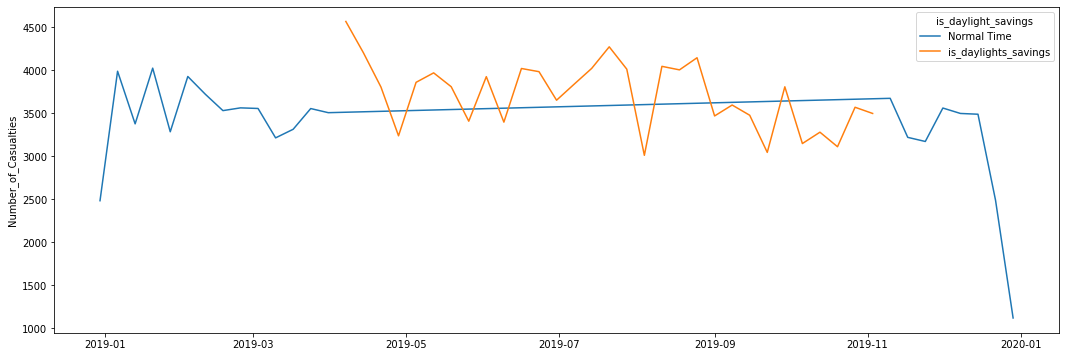

In [120]:

ax = plt.figure(figsize=(18, 6))
ax = sns.lineplot(x=expr_df.index.values, y='Number_of_Casualties', 
                 hue='is_daylight_savings', data=expr_df)
plt.show()

### 1e.	What impact, if any, does sunrise and sunset times have on road traffic accidents?

+ Sunrise Time Assumption: 6am - 7am
+ Normal Time: 7:00am - 6:00pm
+ Sunset Period: 6:35am - 7:00pm 


- H0: Sunrise and Sunset times have an impact on the number of accidents that occurrred 
- H1: Sunrise and Sunset times do not have an impact on the number of accidents that occur

In [121]:
cas_df.head(2)

,Day_of_Week,Number_of_Casualties,Number_of_Vehicles,Casualty_Severity,Accident_Severity,date_time,hour_of_day,Time_Duration
0,Monday,3,2,Slight,Slight,2019-02-18 17:00:00,17,3pm -6pm
1,Monday,3,2,Slight,Slight,2019-02-18 17:00:00,17,3pm -6pm


In [122]:

# Find out if there is an impact visually on the number of casualties
# Bucketize the Sunrise and sunset timestamps 


cas_df['Is_sunrise_or_sunset'] = np.where(
                                    (cas_df['hour_of_day'] >= 6) & (cas_df['hour_of_day'] <= 7), "Sunrise", 
                                np.where(
                                    (cas_df['hour_of_day'] >= 18) & (cas_df['hour_of_day'] <= 19), "Sunset", "normal_time")) 

<AxesSubplot:xlabel='Is_sunrise_or_sunset'>

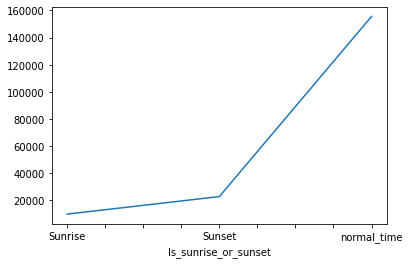

In [123]:
cas_df.groupby(['Is_sunrise_or_sunset'])['Number_of_Casualties'].sum().plot()

In [124]:
# testing the significance of the sunrise and sunset effect using Chi-square test

cas_df['Is_sunrise_or_sunset'].describe()
print(np.percentile(cas_df['Number_of_Casualties'], 50))

1.0


In [126]:
cas_df['Number_of_Casualties_Percentile'] = np.where(
                                    (cas_df['Number_of_Casualties'] <= np.percentile(cas_df['Number_of_Casualties'], 50)), 0, 
                                np.where(
                                    (cas_df['Number_of_Casualties'] > np.percentile(cas_df['Number_of_Casualties'], 50)), 1, "indifferent"))


In [129]:
cas_df['is_sunrise_or_sunset_percentile'] = np.where(
    (cas_df['Is_sunrise_or_sunset'] == "Sunrise")  | (cas_df['Is_sunrise_or_sunset'] == 'Sunset'), 0, 1)


In [130]:
chi_df = cas_df[['is_sunrise_or_sunset_percentile',
                 'Number_of_Casualties_Percentile']]
chi_df['is_sunrise_or_sunset_percentile'] = chi_df['is_sunrise_or_sunset_percentile'].astype(
    'int64')
chi_df['Number_of_Casualties_Percentile'] = chi_df['Number_of_Casualties_Percentile'].astype(
    'int64')

stat, p, dof, expected = chi2_contingency(pd.crosstab(
    chi_df['is_sunrise_or_sunset_percentile'], chi_df['Number_of_Casualties_Percentile']))
print("The degree of freedom is: ", dof)


The degree of freedom is:  1


In [131]:
prob= 0.95
alpha = 1-prob 
print("The significance level is: ", alpha)
print("The p-value is: ", p)
if p <= alpha:
    print("The null hypothesis can be rejected, there is an impact on the number of casualties")
else:
    print('Accept the Null Hypothesis, there is no impact on the number of casualties')


The significance level is:  0.050000000000000044
The p-value is:  6.989297036920644e-25
The null hypothesis can be rejected, there is an impact on the number of casualties


In [132]:
stats.wilcoxon(chi_df['Number_of_Casualties_Percentile'],
               chi_df['is_sunrise_or_sunset_percentile'])


WilcoxonResult(statistic=218435946.0, pvalue=0.0)

#### 1f.	Are there particular types of vehicles (engine capacity, age of vehicle, etc.) that are more frequently involved in road traffic accidents?

In [145]:

vehicle_type_dict = {

    1: 'Bicycle', 2: 'Motorcycle', 3: 'Motorcycle', 4: 'Motorcycle', 5: 'Motorcycle', 8: 'Car', 9: 'Car', 10: "Bus/Vans", 11: "Bus/Vans",
    16: "Others", 17: "Others", 18: "Others", 19: "Bus/Vans", 20: "Goods Vehicles",
    21: "Goods Vehicles", 22: "Others", 23: "Motorcycle", 90: "Others", 97: "Motorcycle",
    98: "Goods Vehicles", -1: "Data missing or out of range"
    
    }

cas_df['Vehicle_Type'] = over_df['Vehicle_Type'].replace(vehicle_type_dict)


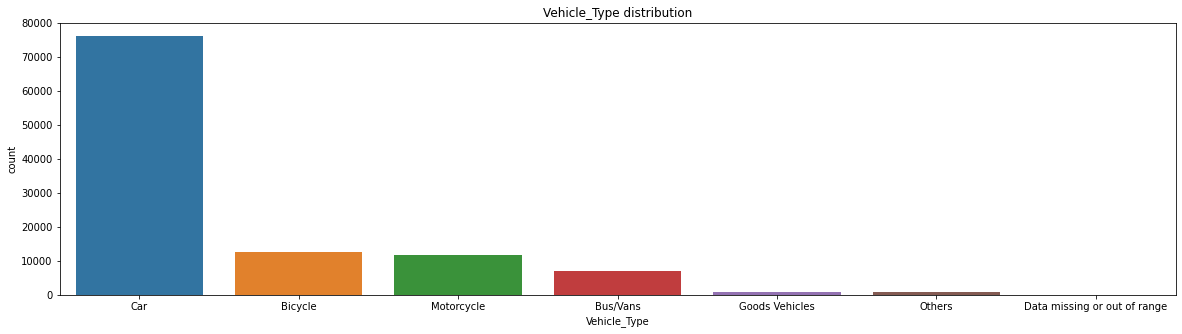

In [149]:
plot_count(['Vehicle_Type'], cas_df)

In [159]:

#drop missing age values, for clarity 
over_df.drop(over_df[over_df.Age_of_Vehicle == -1].index, inplace=True)

In [160]:
over_df.Age_of_Vehicle.describe()


count   77,668.00
mean         8.33
std          5.50
min          1.00
25%          4.00
50%          8.00
75%         12.00
max         94.00
Name: Age_of_Vehicle, dtype: float64

In [172]:
over_df['Age_range_vehicle'] = pd.qcut(over_df.Age_of_Vehicle, 10, labels=False)

In [177]:
over_df['Vehicle_Age_Interval'] = np.where(
        (over_df['Age_range_vehicle'] >= 0) & (over_df['Age_range_vehicle'] < 2), "0-2",
    np.where(
        (over_df['Age_range_vehicle'] >= 2) & (over_df['Age_range_vehicle'] < 5), "2-4", 
    np.where(
        (over_df['Age_range_vehicle'] >= 5) & (over_df['Age_range_vehicle'] < 8), "4-8", "8+"
        )))


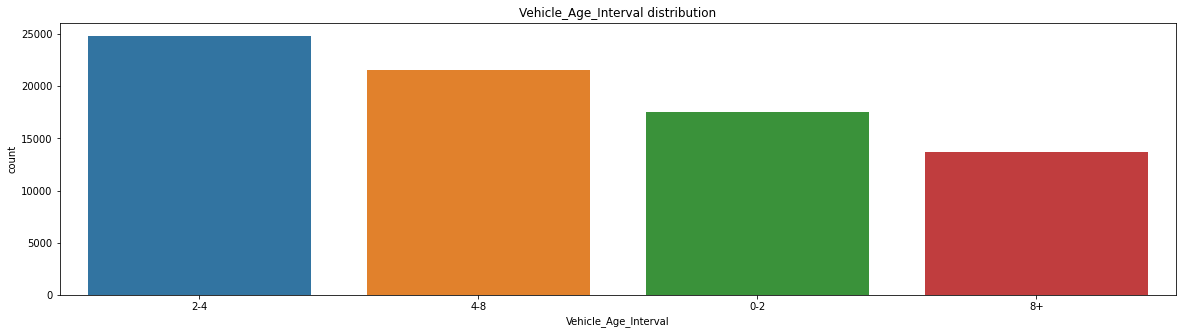

In [179]:
plot_count(['Vehicle_Age_Interval'], over_df)